In [1]:
import os
import sys
custom_paths = ['../src/', '../cifar-10.1-pytorch/', '../data-copying/', '../PyTorch_CIFAR10/']
for path in custom_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(f"Added {os.path.abspath(path)} to path")

Added /nfs/home/cybai/PyTorch-StudioGAN/src to path
Added /nfs/home/cybai/PyTorch-StudioGAN/cifar-10.1-pytorch to path
Added /nfs/home/cybai/PyTorch-StudioGAN/data-copying to path
Added /nfs/home/cybai/PyTorch-StudioGAN/PyTorch_CIFAR10 to path


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.special import softmax
import os
import ast
import glob
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# import custom

import cifar10_models
reload(cifar10_models)

import cifar10_1
reload(cifar10_1)

from data_utils import cifair
reload(cifair)

from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

from utils import load_checkpoint
reload(load_checkpoint)

from metrics.FID import calculate_frechet_distance

import misc
reload(misc)

import data_copying_tests
reload(data_copying_tests)

<module 'data_copying_tests' from '/nfs/home/cybai/PyTorch-StudioGAN/data-copying/data_copying_tests.py'>

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda'
torch.backends.cudnn.benchmark = True

In [4]:
cifar10_classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trucks']

In [5]:
cifar10_1_dset = cifar10_1.CIFAR10_1_v6('../data/cifar10_1',
                                         transform=transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(0.5, 0.5)]), 
                                         download=True) # range = [-1, 1]
cifar10_train_dset = datasets.CIFAR10('../data/cifar10', train=True, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifar10_test_dset = datasets.CIFAR10('../data/cifar10', train=False, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifair10_dset = cifair.ciFAIR10('../data/cifair10', train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(0.5, 0.5)]), 
                                download=True) # range = [-1, 1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
ref_dsets = {'cifar10_1': cifar10_1_dset, 'cifar10_train': cifar10_train_dset,
                'cifar10_test': cifar10_test_dset, 'cifair10': cifair10_dset}
ref_dls = {k: DataLoader(v, batch_size=50, shuffle=False, num_workers=8, drop_last=False)
           for k, v in ref_dsets.items()}

In [7]:
proj_model = inception.WrappedInception3().eval().to(device)

##### trainable parameters

#####


In [8]:
feats = {}
labels = {}
for dset_name, dl in ref_dls.items():
    (xs_, ys_), feats_, logits_ = misc.project(dl, proj_model, n_samples=None, to_numpy=True)
    # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
    feats[dset_name] = feats_
    labels[dset_name] = ys_
    print(dset_name, feats_.shape, ys_.shape)

cifar10_1 (2000, 2048) (2000,)
cifar10_train (50000, 2048) (50000,)
cifar10_test (10000, 2048) (10000,)
cifair10 (10000, 2048) (10000,)


In [15]:
new_train_indices, new_test_indices = [], []
n_test = 10000

for n_class in range(10):
    class_indices = np.arange(labels['cifar10_train'].shape[0])[labels['cifar10_train'] == n_class]
    np.random.shuffle(class_indices)
    new_train_indices.append(class_indices[:-n_test // 10])
    new_test_indices.append(class_indices[-n_test // 10:])
new_train_indices = np.concatenate(new_train_indices)
new_test_indices = np.concatenate(new_test_indices)
print(new_train_indices.shape, new_test_indices.shape)

(40000,) (10000,)


In [16]:
feats['cifar10_train_new'] = feats['cifar10_train'][new_train_indices]
feats['cifar10_test_new'] = feats['cifar10_train'][new_test_indices]
labels['cifar10_train_new'] = labels['cifar10_train'][new_train_indices]
labels['cifar10_test_new'] = labels['cifar10_train'][new_test_indices]

In [24]:
del feats['cifar10_train'], labels['cifar10_train']

In [29]:
train_dset_name = 'cifar10_train_new'

In [25]:
dset_inception_means, dset_inception_covs = {}, {}
for dset_name, feat in feats.items():
    dset_inception_means[dset_name] = np.mean(feat, axis=0)
    dset_inception_covs[dset_name] = np.cov(feat, rowvar=False)

In [26]:
fids = {}
for dset_name in feats.keys():
    if dset_name == train_dset_name:
        continue
    fids[dset_name] = calculate_frechet_distance(dset_inception_means[dset_name], 
                                                 dset_inception_covs[dset_name],
                                                 dset_inception_means[train_dset_name], 
                                                 dset_inception_covs[train_dset_name])

([<matplotlib.axis.XTick at 0x7f4bf042e990>,
 [Text(0, 0, 'cifar10_1'),
  Text(1, 0, 'cifar10_test'),
  Text(2, 0, 'cifair10'),
  Text(3, 0, 'cifar10_test_new')])

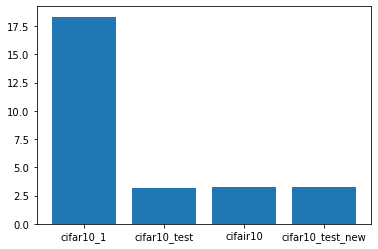

In [28]:
plt.bar(np.arange(len(fids)), fids.values())
plt.xticks(np.arange(len(fids)), labels=fids.keys())

In [30]:
test_dset_name = 'cifar10_test_new'

In [39]:
class_C_Ts = {}
for n_class in range(10):
    print(f"n_class = {n_class}")
    train_pool = feats[train_dset_name][labels[train_dset_name] == n_class]

    pca_xf = PCA(n_components=64).fit(train_pool)
    train_pca = pca_xf.transform(train_pool)

    n_clusters = min(feats[test_dset_name].shape[0], train_pool.shape[0]) // 250
    km_clf = KMeans(n_clusters=n_clusters).fit(train_pca)
    T_labels = km_clf.predict(train_pca)

    test_pool = feats[test_dset_name][labels[test_dset_name] == n_class]

    test_pca = pca_xf.transform(test_pool)
    Pn_labels = km_clf.predict(test_pca)
    
    C_Ts = {}
    for dset_name in feats.keys():

        if dset_name == train_dset_name or dset_name == test_dset_name:
            continue

        gen_pool = feats[dset_name][labels[dset_name] == n_class]
        gen_pca = pca_xf.transform(gen_pool)
        Qm_labels = km_clf.predict(gen_pca)
        
        C_T = data_copying_tests.C_T(test_pool, Pn_labels, gen_pool, Qm_labels, 
                                     train_pool, T_labels, tau=20 / len(gen_pool))

        C_Ts[dset_name] = C_T

    class_C_Ts[n_class] = C_Ts

n_class = 0
n_class = 1
n_class = 2
n_class = 3
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9


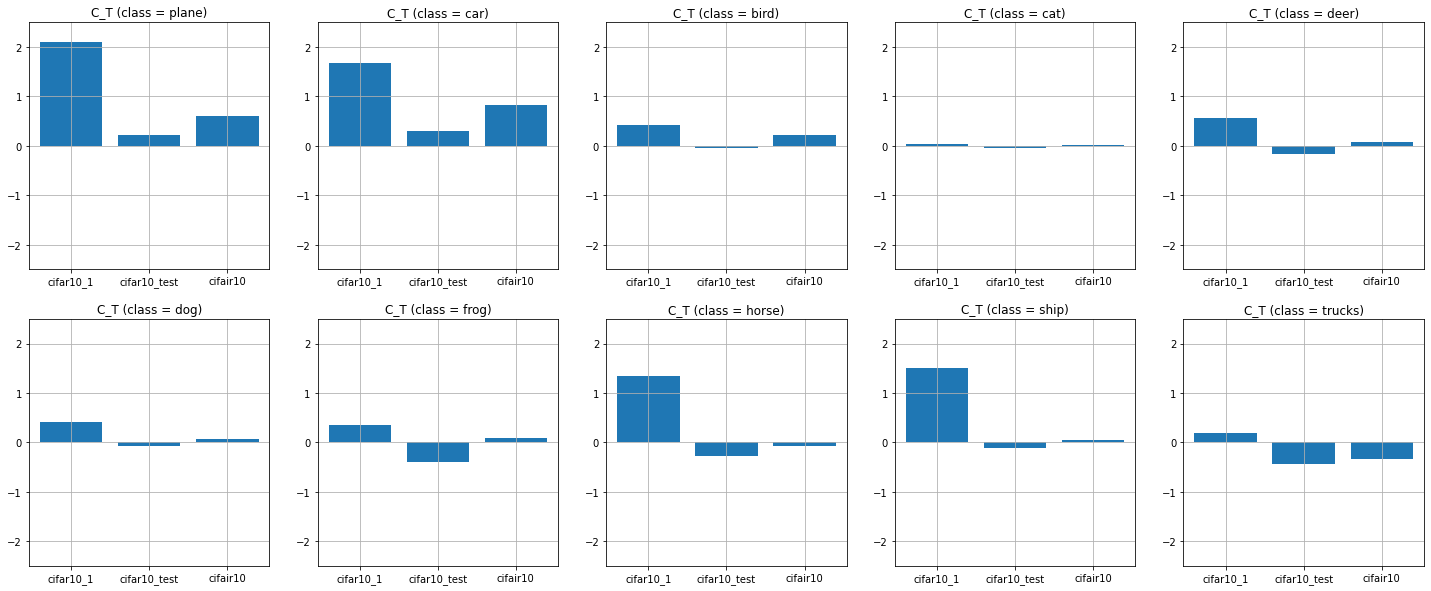

In [44]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for (n_class, C_Ts), ax in zip(class_C_Ts.items(), axs.flat):

    ax.bar(np.arange(len(C_Ts)), C_Ts.values())
    ax.set_xticks(np.arange(len(C_Ts)))
    ax.set_xticklabels(C_Ts.keys())
    ax.set_ylim(-2.5, 2.5)
    ax.grid()
    ax.set_title(f"C_T (class = {cifar10_classnames[n_class]})")

In [45]:
nnds, nnd_indices = misc.calculate_knnd_numpy(target_feats=feats[test_dset_name], 
                                              ref_feats=feats[train_dset_name])

In [46]:
nnd_ordered_indices = np.argsort(nnds)

In [48]:
hist, bin_edges = np.histogram(nnds, bins=50)

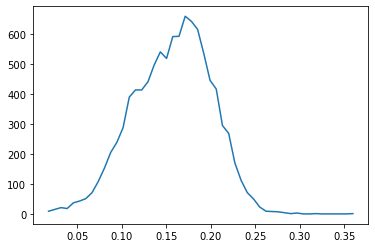

In [50]:
plt.plot(bin_edges[:-1], hist)